In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# Define the path to the new directory
dataset_dir = '/content/drive/My Drive/KITTI_Dataset'

# Create the directory if it doesn't exist
os.makedirs(dataset_dir, exist_ok=True)


In [ ]:
!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# Install Kaggle API client
!pip install kaggle

# Download the dataset to the specified directory
!kaggle datasets download -d klemenko/kitti-dataset -p "{dataset_dir}"

In [ ]:


import zipfile
from tqdm import tqdm

# Define a function to extract files from a zip archive with progress tracking
def extract_with_progress(zip_file, extract_path):
    """
    Extracts files from a zip archive to a specified directory with progress tracking.

    Args:
        zip_file (str): Path to the zip file.
        extract_path (str): Path to the directory where files will be extracted.
    """
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        # Get the total number of files in the zip
        total_files = len(zip_ref.infolist())

        # Iterate over each file and extract with progress bar
        for file in tqdm(zip_ref.infolist(), desc='Extracting', unit='files', total=total_files):
            zip_ref.extract(file, extract_path)

# Prompt the user to enter the path to the zip file and the extraction directory
print("Please provide the path to the zip file and the extraction directory.")
print("Example zip file path: '/content/drive/My Drive/example_folder/example.zip'")
zip_file_path = '/content/drive/My Drive/KITTI_Dataset/kitti-dataset.zip'

print("Example extraction directory path: '/content/drive/My Drive/example_folder'")
extract_path = '/content/drive/My Drive/KITTI_Dataset'

# Call the function to extract with progress tracking
extract_with_progress(zip_file_path, extract_path)

Please provide the path to the zip file and the extraction directory.
Example zip file path: '/content/drive/My Drive/example_folder/example.zip'
Example extraction directory path: '/content/drive/My Drive/example_folder'


Extracting: 100%|██████████| 52478/52478 [31:14<00:00, 28.00files/s]


# Main Part


Number of images in dataset: 7481


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


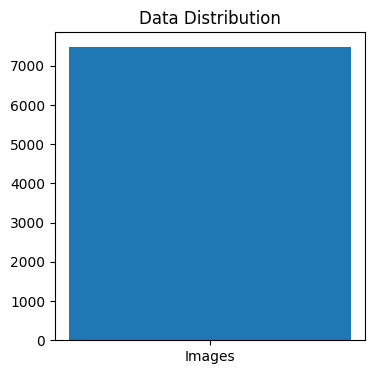

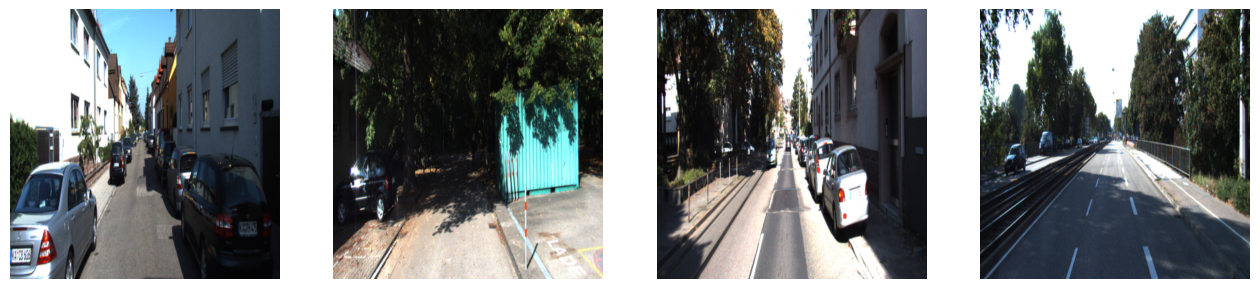

Error loading image /content/drive/My Drive/KITTI_Dataset/data_object_image_2/training/image_2/004307.png: image file is truncated
Epoch 1/2 - Train Loss: 0.8562904753107593
Error loading image /content/drive/My Drive/KITTI_Dataset/data_object_image_2/training/image_2/004307.png: image file is truncated
Epoch 2/2 - Train Loss: 0.8233645411138069


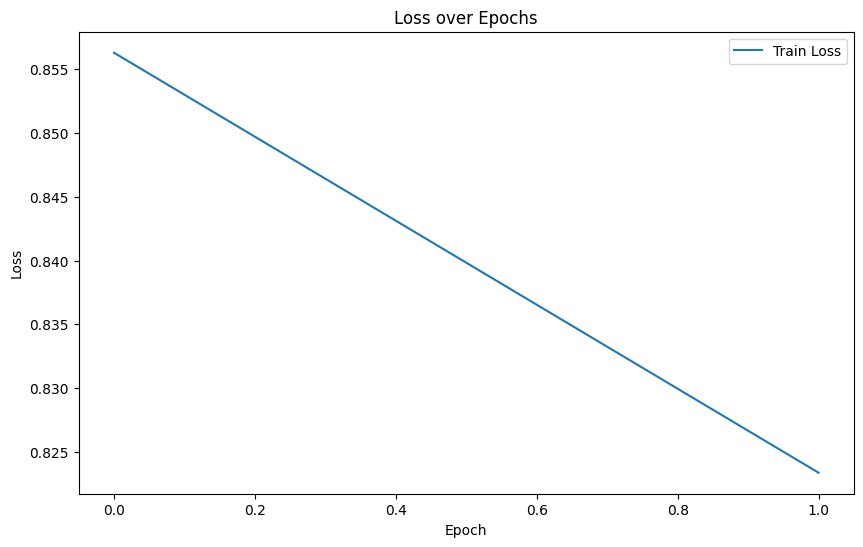

Model may still be converging or needs more epochs.
Training completed. Check synthetic images and losses for qualitative and quantitative insights.


In [1]:
import os
import math
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy

# ----------------------------- #
# KITTI Dataset
# ----------------------------- #
class KittiDataset(Dataset):
    def __init__(self, root_dir, split='train', image_set='image_2', transform=None, max_samples=None):
        self.root_dir = root_dir
        self.split = split
        self.image_set = image_set
        self.transform = transform

        self.image_dir = os.path.join(
            self.root_dir,
            'data_object_image_2' if image_set == 'image_2' else 'data_object_image_3',
            'training' if split == 'train' else 'testing',
            image_set
        )

        self.image_files = sorted(os.listdir(self.image_dir))
        if max_samples:
            self.image_files = self.image_files[:max_samples]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image if there's an error
            return torch.zeros(3, 480, 480)

        if self.transform:
            image = self.transform(image)
        return image

# ----------------------------- #
# Decoder Block for U-Net
# ----------------------------- #
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels + out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

# ----------------------------- #
# ResNet-Based U-Net
# ----------------------------- #
class ResNetUNet(nn.Module):
    def __init__(self, pretrained=True, use_batchnorm=False, dropout_rate=0.0):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None)

        # Encoder
        self.enc1 = nn.Sequential(*list(resnet.children())[:3])  # [64 channels]
        self.enc2 = nn.Sequential(*list(resnet.children())[3:5]) # [256 channels]
        self.enc3 = resnet.layer2 # [512 channels]
        self.enc4 = resnet.layer3 # [1024 channels]
        self.enc5 = resnet.layer4 # [2048 channels]

        # Optionally add Batch Normalization after enc5 output
        self.bn = nn.BatchNorm2d(2048) if use_batchnorm else nn.Identity()

        # Decoder
        self.dec4 = DecoderBlock(2048, 1024)
        self.dec3 = DecoderBlock(1024, 512)
        self.dec2 = DecoderBlock(512, 256)
        self.dec1 = DecoderBlock(256, 64)

        # Final convolution
        self.final_conv = nn.Conv2d(64 + 64, 3, kernel_size=1)
        self.final_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Optional dropout in decoder
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)
        enc5 = self.bn(enc5)

        # Decoder with skip connections
        dec4 = self.dec4(enc5, enc4)
        dec4 = self.dropout(dec4)
        dec3 = self.dec3(dec4, enc3)
        dec3 = self.dropout(dec3)
        dec2 = self.dec2(dec3, enc2)
        dec2 = self.dropout(dec2)
        dec1 = self.dec1(dec2, enc1)
        dec1 = self.dropout(dec1)

        out = self.final_conv(torch.cat([dec1, enc1], dim=1))
        out = self.final_upsample(out)
        return out

# ----------------------------- #
# Beta Schedule
# ----------------------------- #
def make_beta_schedule(schedule, n_timestep):
    if schedule == 'cosine':
        timesteps = np.arange(n_timestep + 1, dtype=np.float64) / n_timestep
        alphas = np.cos(timesteps * math.pi / 2)**2
        betas = 1 - alphas[1:] / alphas[:-1]
        return betas.clip(max=0.999)
    else:
        raise ValueError(f"Unknown schedule: {schedule}")

# ----------------------------- #
# EMA Class
# ----------------------------- #
class EMA():
    def __init__(self, beta=0.999):
        super().__init__()
        self.beta = beta

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            ma_params.data = ma_params.data * self.beta + current_params.data * (1 - self.beta)

# ----------------------------- #
# Diffusion Model
# ----------------------------- #
class DiffusionModel(nn.Module):
    def __init__(self, unet, beta_schedule, num_timesteps=1000, device='cpu'):
        super().__init__()
        self.unet = unet
        self.num_timesteps = num_timesteps

        # Create betas and move them to the appropriate device
        self.betas = torch.tensor(beta_schedule, dtype=torch.float32, device=device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0).to(device)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        # 't' is on the device of x_start, so ensure alphas_cumprod is also on the same device
        alpha = self.alphas_cumprod[t].view(-1, 1, 1, 1)
        return torch.sqrt(alpha) * x_start + torch.sqrt(1 - alpha) * noise

    def p_sample(self, x_t, t, noise):
        pred_noise = self.unet(x_t)
        alpha = self.alphas_cumprod[t].view(-1, 1, 1, 1)
        return torch.sqrt(alpha) * pred_noise + torch.sqrt(1 - alpha) * noise

    def forward(self, x_start, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        batch_size = x_start.size(0)
        # Move t to the correct device. Normally, t is already on the same device as x_start.
        t = torch.randint(0, self.num_timesteps, (batch_size,), device=x_start.device).long()
        x_t = self.q_sample(x_start, t, noise)
        pred_noise = self.unet(x_t)
        return nn.MSELoss()(pred_noise, noise)

# ----------------------------- #
# Utility Functions
# ----------------------------- #
def visualize_data_distribution(dataset):
    print("Number of images in dataset:", len(dataset))
    plt.figure(figsize=(4,4))
    plt.bar(['Images'], [len(dataset)])
    plt.title("Data Distribution")
    plt.show()

def show_sample_images(dataset, num_samples=4):
    fig, axes = plt.subplots(1, num_samples, figsize=(4*num_samples,4))
    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        img = dataset[idx]
        # Denormalize for display
        img = img * 0.5 + 0.5
        img_np = img.permute(1,2,0).numpy()
        axes[i].imshow(img_np)
        axes[i].axis('off')
    plt.show()

def train_one_epoch(model, ema_model, dataloader, optimizer, device, gradient_clipping=None):
    model.train()
    running_loss = 0.0
    ema = EMA(beta=0.999)
    for images in dataloader:
        images = images.to(device)
        noise = torch.randn_like(images)
        optimizer.zero_grad()
        loss = model(images, noise=noise)
        loss.backward()

        if gradient_clipping is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)

        optimizer.step()
        ema.update_model_average(ema_model, model)
        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    return avg_loss

def generate_synthetic_images(model, device, num_timesteps, image_size, num_images=4, output_dir="synthetic_images", epoch=0):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    with torch.no_grad():
        y_t = torch.randn((num_images, 3, image_size, image_size), device=device)
        for i in reversed(range(num_timesteps)):
            noise = torch.randn_like(y_t)
            y_t = model.p_sample(y_t, i, noise=noise)

    y_t = (y_t.clamp(-1, 1) + 1) / 2
    for i, img in enumerate(y_t):
        img_pil = transforms.ToPILImage()(img.cpu())
        img_pil.save(os.path.join(output_dir, f"synthetic_epoch{epoch + 1}_sample{i}.png"))

def plot_loss_curves(train_losses):
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, label='Train Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Placeholder for advanced metric like FID (not implemented here)
def compute_fid(real_images_dir, generated_images_dir):
    # If you implement or integrate an FID library, do it here.
    # Returning a dummy value for demonstration.
    return 100.0

# ----------------------------- #
# Main Execution
# ----------------------------- #

if __name__ == "__main__":
    # Configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset_dir = '/content/drive/My Drive/KITTI_Dataset'
    image_size = 480
    epochs = 2   # You can adjust this
    batch_size = 6
    lr = 1e-4
    num_timesteps = 1000
    output_dir = "synthetic_images"

    # Transform
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Dataset and DataLoader
    train_dataset = KittiDataset(dataset_dir, split='train', transform=transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

    # Visualizations
    visualize_data_distribution(train_dataset)
    show_sample_images(train_dataset)

    # Model initialization
    # Try changing these parameters (use_batchnorm, dropout_rate) and compare results
    unet = ResNetUNet(pretrained=True, use_batchnorm=True, dropout_rate=0.2).to(device)
    beta_schedule = make_beta_schedule('cosine', num_timesteps)
    model = DiffusionModel(unet, beta_schedule, num_timesteps=num_timesteps, device=device).to(device)
    ema_model = deepcopy(model)

    # Optimizer with L2 regularization via weight_decay
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # Lists to store training losses
    train_losses = []

    # Gradient clipping value
    gradient_clipping = 1.0

    # Training loop
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, ema_model, train_dataloader, optimizer, device, gradient_clipping=gradient_clipping)
        train_losses.append(train_loss)

        # Save model checkpoints
        torch.save(model.state_dict(), os.path.join(dataset_dir, f"Res_model_epoch_{epoch + 1}.pth"))
        torch.save(ema_model.state_dict(), os.path.join(dataset_dir, f"Res_ema_model_epoch_{epoch + 1}_ema.pth"))

        # Generate synthetic images for qualitative evaluation
        generate_synthetic_images(model, device, num_timesteps, image_size, num_images=4, output_dir=output_dir, epoch=epoch)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss}")

    # Plot the loss curves
    plot_loss_curves(train_losses)

    # Check for convergence
    if len(train_losses) > 5 and abs(train_losses[-1] - train_losses[-5]) < 0.001:
        print("Model seems to have converged.")
    else:
        print("Model may still be converging or needs more epochs.")

    # Without validation data, difficult to judge overfitting/underfitting.
    # Typically, you'd compare training and validation losses over epochs.
    print("Training completed. Check synthetic images and losses for qualitative and quantitative insights.")
